In [8]:
import pandas as pd

In [9]:
# import data
sdg_in = pd.read_excel('SDG-DEA_indicators_V3_20200428.xlsx',
                       sheet_name='SDG-DEA FINAL',
                       header=5,
                       index_col=0,
                       usecols='B,S:DQ',
                    #    skiprows=[5]
                       )

dir_sdg_in = pd.read_excel('SDG-DEA_indicators_V3_20200428.xlsx',
                             sheet_name='SDG-DEA FINAL',
                             usecols='T:DQ',
                             nrows=2,
                             skiprows=[0,1],
                             header=None
                             )

In [10]:
# name first column and fill missing data
inds = sdg_in.copy()
inds.columns = ['gdppc',*inds.columns[1:]]
inds.fillna(inds.mean(axis=0), inplace=True)

In [11]:
# convert indicators to "output" direction (i.e. should be more positive with higher GDPPC)
dir_sdg = dir_sdg_in.loc[0,:].copy()
dir_sdg = pd.Series([1]).append(dir_sdg)
dir_sdg.index = inds.columns
inds_allout = inds.mul(dir_sdg, axis=1)

In [12]:
# calculate correlation of indicators with gdp per capita
pearson_corr = inds_allout.corr().loc['gdppc',:] 
psn_neg_sorted = pearson_corr[pearson_corr < 0].sort_values() # indicators with negative correlation, sorted

In [18]:
import seaborn as sns
# import matplotlib.pyplot as plt

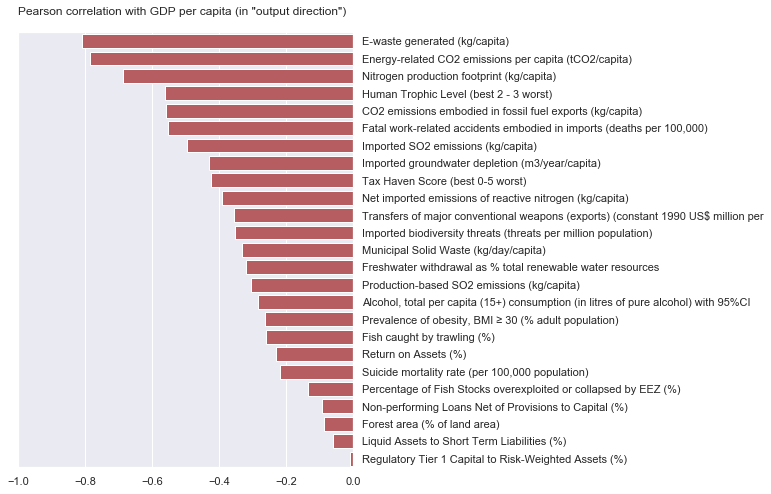

In [24]:
# plot bar chart of indicators with negative correlations
sns.set(rc={'figure.figsize':(6,8)})
b = sns.barplot(psn_neg_sorted.values, psn_neg_sorted.index, orient='h', color='r')
b.set_xlim(-1,0)
b.yaxis.set_ticks_position('right')
b.yaxis.set_ticks_position('none')
plt.xlabel('abcd', ha='left')

b.set(xlabel='Pearson correlation with GDP per capita (in "output direction")')
b.xaxis.set_label_position('top')
b.xaxis.labelpad = 5

b.xaxis.set_label_coords(0, 1.04)

b.get_figure().savefig('isotonicity_exclude.png', dpi=600, bbox_inches='tight')


In [58]:
# forward fill sdg data NaNs
dir_sdg = dir_sdg_in.copy()
dir_sdg.index = ['direction','sdg']
dir_sdg = dir_sdg.fillna(method='ffill', axis=1)

# combine correlation with sdg, also remove space between sdg and number while we're at it
psn_sdg = pearson_corr[1:].to_frame()
psn_sdg['sdg'] = [''.join(ii.split(' ')) for ii in dir_sdg.loc['sdg',:].values]

# calculate how many indicators need to be removed/kept for each SDG due to isotonicity issues
iso_rem = pd.DataFrame(columns=['keep','remove'], index=range(1,psn_sdg['sdg'].unique().shape[0]+1))
for ii,s in enumerate(psn_sdg['sdg'].unique()):
    iso_rem.loc[ii+1,'remove'] = psn_sdg[(psn_sdg['sdg']==s) & (psn_sdg['gdppc']<0)].shape[0]
    iso_rem.loc[ii+1,'keep'] = psn_sdg[(psn_sdg['sdg']==s) & (psn_sdg['gdppc']>=0)].shape[0]

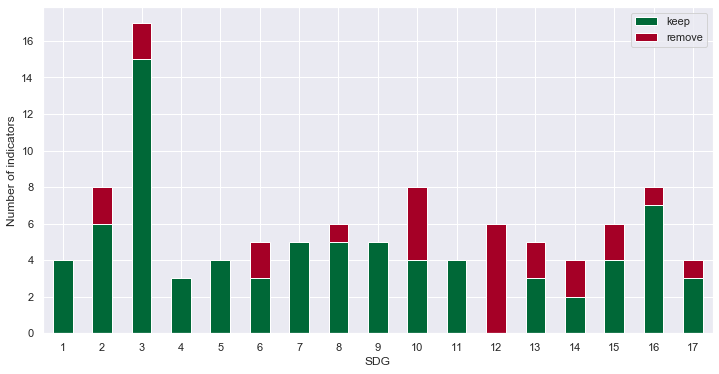

In [61]:
# stacked bar chart of how many indicators get kept/removed for each sdg
import seaborn as sns
sns.set()
ax = iso_rem.plot(kind='bar', stacked=True, figsize=(12,6), colormap='RdYlGn_r')
ax.set_ylabel('Number of indicators')
ax.set_xlabel('SDG')
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
ax.get_figure().savefig('indicators_keep_remove.png', dpi=600, bbox_inches='tight')

